In [88]:
import numpy as np
import pandas as pd
import json
import re
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datapath = '../data/redd/low_freq/'
dishwasher_channel = 

In [5]:
labels = pd.read_csv('../data/redd/low_freq/house_1/labels.dat',sep='\s+',header=None)
labels.to_dict()

{0: {0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 11,
  11: 12,
  12: 13,
  13: 14,
  14: 15,
  15: 16,
  16: 17,
  17: 18,
  18: 19,
  19: 20},
 1: {0: 'mains',
  1: 'mains',
  2: 'oven',
  3: 'oven',
  4: 'refrigerator',
  5: 'dishwaser',
  6: 'kitchen_outlets',
  7: 'kitchen_outlets',
  8: 'lighting',
  9: 'washer_dryer',
  10: 'microwave',
  11: 'bathroom_gfi',
  12: 'electric_heat',
  13: 'stove',
  14: 'kitchen_outlets',
  15: 'kitchen_outlets',
  16: 'lighting',
  17: 'lighting',
  18: 'washer_dryer',
  19: 'washer_dryer'}}

In [12]:
def read_house_channels(datapath):
    app_channel_dict = {}
    for i in range(1,7):
        path = datapath + 'house_{}/labels.dat'.format(i)
        df = pd.read_csv(path, sep='\s+', header=None)
        channel_n = df[0].to_list()
        appliance = df[1].to_list()
        house_n = 'house_{}'.format(i)
        app_channel_dict[house_n] = {app + '_' + str(chan): chan for app, chan in list(zip(appliance,channel_n))}
    return app_channel_dict

app_channel_dict = read_house_channels(datapath)
print(json.dumps(app_channel_dict, indent=4))

{
    "house_1": {
        "mains_1": 1,
        "mains_2": 2,
        "oven_3": 3,
        "oven_4": 4,
        "refrigerator_5": 5,
        "dishwaser_6": 6,
        "kitchen_outlets_7": 7,
        "kitchen_outlets_8": 8,
        "lighting_9": 9,
        "washer_dryer_10": 10,
        "microwave_11": 11,
        "bathroom_gfi_12": 12,
        "electric_heat_13": 13,
        "stove_14": 14,
        "kitchen_outlets_15": 15,
        "kitchen_outlets_16": 16,
        "lighting_17": 17,
        "lighting_18": 18,
        "washer_dryer_19": 19,
        "washer_dryer_20": 20
    },
    "house_2": {
        "mains_1": 1,
        "mains_2": 2,
        "kitchen_outlets_3": 3,
        "lighting_4": 4,
        "stove_5": 5,
        "microwave_6": 6,
        "washer_dryer_7": 7,
        "kitchen_outlets_8": 8,
        "refrigerator_9": 9,
        "dishwaser_10": 10,
        "disposal_11": 11
    },
    "house_3": {
        "mains_1": 1,
        "mains_2": 2,
        "outlets_unknown_3": 3,
     

In [21]:
# We are choosing refrigerator and dishwasher
app_chan = defaultdict(dict)
for house, val in app_channel_dict.items():
    for app, chan in val.items():
        if re.search('mains',app) or re.search('refrigerator', app) \
        or re.search('dishwaser', app):
            app_chan[house][app] = chan
print(json.dumps(app_chan, indent=4))

{
    "house_1": {
        "mains_1": 1,
        "mains_2": 2,
        "refrigerator_5": 5,
        "dishwaser_6": 6
    },
    "house_2": {
        "mains_1": 1,
        "mains_2": 2,
        "refrigerator_9": 9,
        "dishwaser_10": 10
    },
    "house_3": {
        "mains_1": 1,
        "mains_2": 2,
        "refrigerator_7": 7,
        "dishwaser_9": 9
    },
    "house_4": {
        "mains_1": 1,
        "mains_2": 2,
        "dishwaser_15": 15
    },
    "house_5": {
        "mains_1": 1,
        "mains_2": 2,
        "refrigerator_18": 18,
        "dishwaser_20": 20
    },
    "house_6": {
        "mains_1": 1,
        "mains_2": 2,
        "refrigerator_8": 8,
        "dishwaser_9": 9
    }
}


### Feature Generation

In [41]:
def read_appliance_data(datapath, app_chan, 
                        appliance1='refrigerator', appliance2='dishwaser'):
    house_df = {}
    for i, (house, app_dict) in enumerate(app_chan.items()):
        for j, (appliance, channel) in enumerate(app_dict.items()):
            path = datapath + house + '/channel_{}.dat'.format(channel)
            if j == 0:
                df = pd.read_csv(path, sep='\s+', header=None, names=['timestamp',appliance])
                continue
            appliance_name = appliance
            if re.search(appliance1, appliance):
                appliance_name = appliance1
            if re.search(appliance2, appliance):
                appliance_name = appliance2
            d = pd.read_csv(path, sep='\s+', header=None, names=['timestamp', appliance_name])
            df = pd.merge(df, d, how='inner', on='timestamp')
        house_df[house] = df
        
    return house_df

house_df = read_appliance_data(datapath, app_chan)
    

In [42]:
house_df.keys()

dict_keys(['house_1', 'house_2', 'house_3', 'house_4', 'house_5', 'house_6'])

In [49]:
for house in house_df:
    print(house_df[house].info())
    print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406748 entries, 0 to 406747
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     406748 non-null  int64  
 1   mains_1       406748 non-null  float64
 2   mains_2       406748 non-null  float64
 3   refrigerator  406748 non-null  float64
 4   dishwaser     406748 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 18.6 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316840 entries, 0 to 316839
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     316840 non-null  int64  
 1   mains_1       316840 non-null  float64
 2   mains_2       316840 non-null  float64
 3   refrigerator  316840 non-null  float64
 4   dishwaser     316840 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 14.5 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 

In [45]:
house_df['house_3']

,timestamp,mains_1,mains_2,refrigerator,dishwaser
0,1302930690,181.34,577.30,119.0,0.0
1,1302930693,180.74,577.39,118.0,1.0
2,1302930696,182.00,577.88,119.0,0.0
3,1302930700,181.44,578.44,119.0,1.0
4,1302930703,179.95,575.92,117.0,0.0
...,...,...,...,...,...
376145,1306801163,15.47,2.23,8.0,3.0
376146,1306801166,15.48,2.23,8.0,3.0
376147,1306801170,15.45,2.23,8.0,3.0
376148,1306801173,15.42,2.23,8.0,3.0


In [71]:
def generate_features(df, window_size):
    df['mains_1_roll_mean'] = df['mains_1'].rolling(window_size).mean().fillna(method='bfill')
    df['mains_1_roll_max'] = df['mains_1'].rolling(window_size).max().fillna(method='bfill')
    df['mains_1_roll_min'] = df['mains_1'].rolling(window_size).min().fillna(method='bfill')
    df['mains_1_roll_var'] = df['mains_1'].rolling(window_size).var().fillna(method='bfill')
    df['mains_2_roll_mean'] = df['mains_2'].rolling(window_size).mean().fillna(method='bfill')
    df['mains_2_roll_max'] = df['mains_2'].rolling(window_size).max().fillna(method='bfill')
    df['mains_2_roll_min'] = df['mains_2'].rolling(window_size).min().fillna(method='bfill')
    df['mains_2_roll_var'] = df['mains_2'].rolling(window_size).var().fillna(method='bfill')
    df['main1_main2_cov'] = df['mains_1'].rolling(window_size).cov(other=df['mains_2']).fillna(method='bfill')
    return df

df = generate_features(house_df['house_1'], 10)

for house in house_df:
    house_df[house] = generate_features(house_df[house], 10)

In [72]:
house_df['house_1']

,timestamp,mains_1,mains_2,refrigerator,dishwaser,mains_1_roll_mean,mains_1_roll_max,mains_1_roll_min,mains_1_roll_var,mains_2_roll_mean,mains_2_roll_max,mains_2_roll_min,mains_2_roll_var,main1_main2_cov
0,1303132933,222.20,118.83,6.0,0.0,223.221,226.03,222.20,1.106432,118.913,119.19,118.36,0.062401,0.127274
1,1303132936,223.17,119.19,6.0,0.0,223.221,226.03,222.20,1.106432,118.913,119.19,118.36,0.062401,0.127274
2,1303132940,223.60,118.92,6.0,0.0,223.221,226.03,222.20,1.106432,118.913,119.19,118.36,0.062401,0.127274
3,1303132943,222.91,119.16,6.0,1.0,223.221,226.03,222.20,1.106432,118.913,119.19,118.36,0.062401,0.127274
4,1303132946,222.94,118.83,6.0,0.0,223.221,226.03,222.20,1.106432,118.913,119.19,118.36,0.062401,0.127274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406743,1306266980,235.73,38.65,186.0,1.0,235.878,239.92,234.47,2.338373,38.585,38.77,38.30,0.016872,-0.047678
406744,1306266983,235.03,38.66,187.0,0.0,235.723,239.92,234.47,2.336823,38.603,38.77,38.30,0.015912,-0.043454
406745,1306266987,235.46,38.61,190.0,0.0,235.277,235.73,234.47,0.166290,38.607,38.77,38.30,0.015779,-0.026288
406746,1306266990,235.98,38.77,189.0,0.0,235.314,235.98,234.47,0.207360,38.654,38.77,38.51,0.005805,-0.004129


In [73]:
# Use house 1, house 2 ... , house 4 as training and house 5 and house 6 as test
df_train = pd.concat([house_df['house_{}'.format(i)] for i in range(1,5)])
df_test = pd.concat([house_df['house_{}'.format(i)] for i in range(5,7)])
print('Shape of train and test is {} and {}'.format(df_train.shape,df_test.shape))

Shape of train and test is (1527814, 14) and (269643, 14)


In [74]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527814 entries, 0 to 428075
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp          1527814 non-null  int64  
 1   mains_1            1527814 non-null  float64
 2   mains_2            1527814 non-null  float64
 3   refrigerator       1099738 non-null  float64
 4   dishwaser          1527814 non-null  float64
 5   mains_1_roll_mean  1527814 non-null  float64
 6   mains_1_roll_max   1527814 non-null  float64
 7   mains_1_roll_min   1527814 non-null  float64
 8   mains_1_roll_var   1527814 non-null  float64
 9   mains_2_roll_mean  1527814 non-null  float64
 10  mains_2_roll_max   1527814 non-null  float64
 11  mains_2_roll_min   1527814 non-null  float64
 12  mains_2_roll_var   1527814 non-null  float64
 13  main1_main2_cov    1527814 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 174.8 MB
None
<class 'pandas.core.frame.Data

### Train a Baseline model for Dishwaser

In [75]:
features = ['mains_1', 'mains_2', 'mains_1_roll_mean', 'mains_1_roll_max',
           'mains_1_roll_min', 'mains_1_roll_var', 'mains_2_roll_mean', 
           'mains_2_roll_max', 'mains_2_roll_min', 'mains_2_roll_var',
           'main1_main2_cov']
label = ['dishwaser']

dishwaser_df_train = df_train[features]
dishwaser_train_labels = df_train[label]

dishwaser_df_test = df_test[features]
dishwaser_test_labels = df_test[label]

In [76]:
dishwaser_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527814 entries, 0 to 428075
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   mains_1            1527814 non-null  float64
 1   mains_2            1527814 non-null  float64
 2   mains_1_roll_mean  1527814 non-null  float64
 3   mains_1_roll_max   1527814 non-null  float64
 4   mains_1_roll_min   1527814 non-null  float64
 5   mains_1_roll_var   1527814 non-null  float64
 6   mains_2_roll_mean  1527814 non-null  float64
 7   mains_2_roll_max   1527814 non-null  float64
 8   mains_2_roll_min   1527814 non-null  float64
 9   mains_2_roll_var   1527814 non-null  float64
 10  main1_main2_cov    1527814 non-null  float64
dtypes: float64(11)
memory usage: 139.9 MB


In [77]:
dishwaser_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269643 entries, 0 to 192191
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   mains_1            269643 non-null  float64
 1   mains_2            269643 non-null  float64
 2   mains_1_roll_mean  269643 non-null  float64
 3   mains_1_roll_max   269643 non-null  float64
 4   mains_1_roll_min   269643 non-null  float64
 5   mains_1_roll_var   269643 non-null  float64
 6   mains_2_roll_mean  269643 non-null  float64
 7   mains_2_roll_max   269643 non-null  float64
 8   mains_2_roll_min   269643 non-null  float64
 9   mains_2_roll_var   269643 non-null  float64
 10  main1_main2_cov    269643 non-null  float64
dtypes: float64(11)
memory usage: 24.7 MB


In [78]:
model = RandomForestRegressor(n_estimators=100)
model.fit(dishwaser_df_train, dishwaser_train_labels)
dishwaser_pred = model.predict(dishwaser_df_test)

/Users/rijulvohra/opt/anaconda3/envs/practicum/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [85]:
dishwaser_train_pred = model.predict(dishwaser_df_train)

In [103]:
print("RMSE on train set for dishwasher is {}".format(mean_squared_error(dishwaser_train_labels, dishwaser_train_pred, squared=False)))
print("RMSE on test set for dishwasher is {}".format(mean_squared_error(dishwaser_test_labels, dishwaser_pred, squared=False)))

RMSE on train set for dishwasher is 4.602945035140761
RMSE on test set for dishwasher is 73.93046231918974


Feature: mains_1, Score: 0.0225660593823119
Feature: mains_2, Score: 0.031823360503918194
Feature: mains_1_roll_mean, Score: 0.3164467448123172
Feature: mains_1_roll_max, Score: 0.03165268465625587
Feature: mains_1_roll_min, Score: 0.0989763218874175
Feature: mains_1_roll_var, Score: 0.0230990225312848
Feature: mains_2_roll_mean, Score: 0.018133702546762973
Feature: mains_2_roll_max, Score: 0.051853878033894726
Feature: mains_2_roll_min, Score: 0.3563935677799134
Feature: mains_2_roll_var, Score: 0.043409814527183455
Feature: main1_main2_cov, Score: 0.005644843338739976


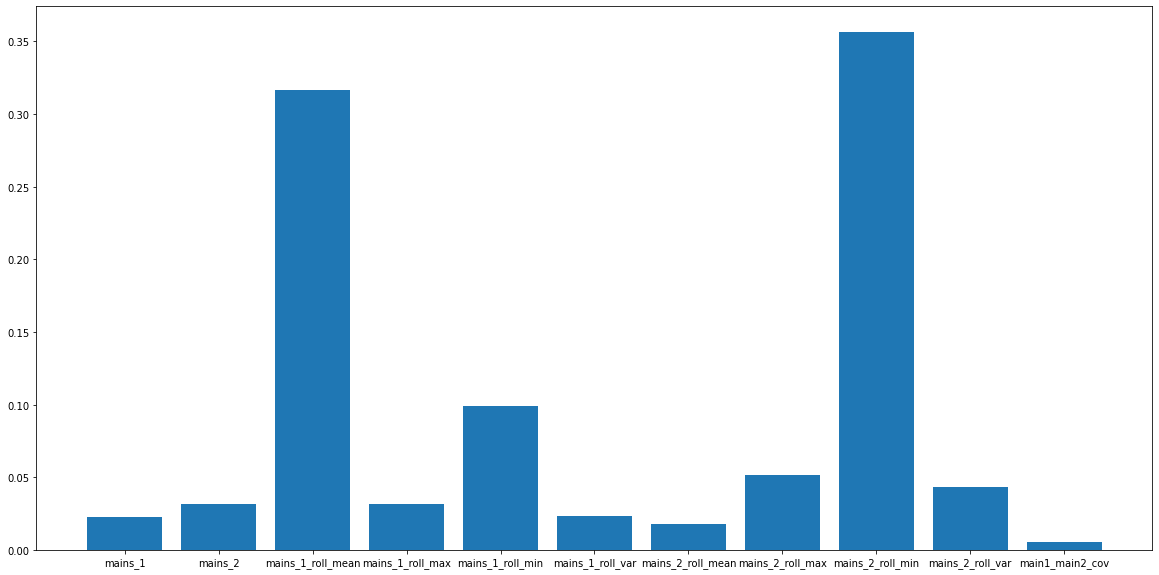

In [93]:
plt.rcParams["figure.figsize"] = (20,10)
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(list(zip(features,importance))):
    print('Feature: {}, Score: {}'.format(v[0],v[1]))
# plot feature importance
plt.bar(features, importance)
plt.show()

In [90]:
print(importance)

[0.02256606 0.03182336 0.31644674 0.03165268 0.09897632 0.02309902
 0.0181337  0.05185388 0.35639357 0.04340981 0.00564484]


### Train a Baseline model for Refrigerator

In [94]:
df_train_ref = pd.concat([house_df['house_{}'.format(i)] for i in range(1,4)])
df_test_ref = pd.concat([house_df['house_{}'.format(i)] for i in range(5,7)])
print('Shape of train and test is {} and {}'.format(df_train_ref.shape, df_test_ref.shape))

Shape of train and test is (1099738, 14) and (269643, 14)


In [95]:
features = ['mains_1', 'mains_2', 'mains_1_roll_mean', 'mains_1_roll_max',
           'mains_1_roll_min', 'mains_1_roll_var', 'mains_2_roll_mean', 
           'mains_2_roll_max', 'mains_2_roll_min', 'mains_2_roll_var',
           'main1_main2_cov']
label = ['refrigerator']

refrigerator_df_train = df_train_ref[features]
refrigerator_train_labels = df_train_ref[label]

refrigerator_df_test = df_test_ref[features]
refrigerator_test_labels = df_test_ref[label]

In [96]:
refrigerator_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099738 entries, 0 to 376149
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   mains_1            1099738 non-null  float64
 1   mains_2            1099738 non-null  float64
 2   mains_1_roll_mean  1099738 non-null  float64
 3   mains_1_roll_max   1099738 non-null  float64
 4   mains_1_roll_min   1099738 non-null  float64
 5   mains_1_roll_var   1099738 non-null  float64
 6   mains_2_roll_mean  1099738 non-null  float64
 7   mains_2_roll_max   1099738 non-null  float64
 8   mains_2_roll_min   1099738 non-null  float64
 9   mains_2_roll_var   1099738 non-null  float64
 10  main1_main2_cov    1099738 non-null  float64
dtypes: float64(11)
memory usage: 100.7 MB


In [97]:
refrigerator_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269643 entries, 0 to 192191
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   mains_1            269643 non-null  float64
 1   mains_2            269643 non-null  float64
 2   mains_1_roll_mean  269643 non-null  float64
 3   mains_1_roll_max   269643 non-null  float64
 4   mains_1_roll_min   269643 non-null  float64
 5   mains_1_roll_var   269643 non-null  float64
 6   mains_2_roll_mean  269643 non-null  float64
 7   mains_2_roll_max   269643 non-null  float64
 8   mains_2_roll_min   269643 non-null  float64
 9   mains_2_roll_var   269643 non-null  float64
 10  main1_main2_cov    269643 non-null  float64
dtypes: float64(11)
memory usage: 24.7 MB


In [98]:
%%time
ref_model = RandomForestRegressor(n_estimators=100)
ref_model.fit(refrigerator_df_train, refrigerator_train_labels)
refrigerator_pred = ref_model.predict(refrigerator_df_test)

/Users/rijulvohra/opt/anaconda3/envs/practicum/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 24min 7s, sys: 4.2 s, total: 24min 11s
Wall time: 24min 14s


In [99]:
refrigerator_train_pred = ref_model.predict(refrigerator_df_train)

In [102]:
print("RMSE on train set for refrigerator is {}".format(mean_squared_error(refrigerator_train_labels, refrigerator_train_pred, squared=False)))
print("RMSE on test set for refrigerator is {}".format(mean_squared_error(refrigerator_test_labels, refrigerator_pred, squared=False)))

RMSE on train set for refrigerator is 7.528039425929213
RMSE on test set for refrigerator is 82.98403059804683


Feature: mains_1, Score: 0.30752669044852426
Feature: mains_2, Score: 0.2703946470160387
Feature: mains_1_roll_mean, Score: 0.03376380633995469
Feature: mains_1_roll_max, Score: 0.027455007143444964
Feature: mains_1_roll_min, Score: 0.13017092074548364
Feature: mains_1_roll_var, Score: 0.02304809640532901
Feature: mains_2_roll_mean, Score: 0.0306746497077158
Feature: mains_2_roll_max, Score: 0.03830375173547409
Feature: mains_2_roll_min, Score: 0.11115121088303553
Feature: mains_2_roll_var, Score: 0.017196862213223963
Feature: main1_main2_cov, Score: 0.010314357361775432


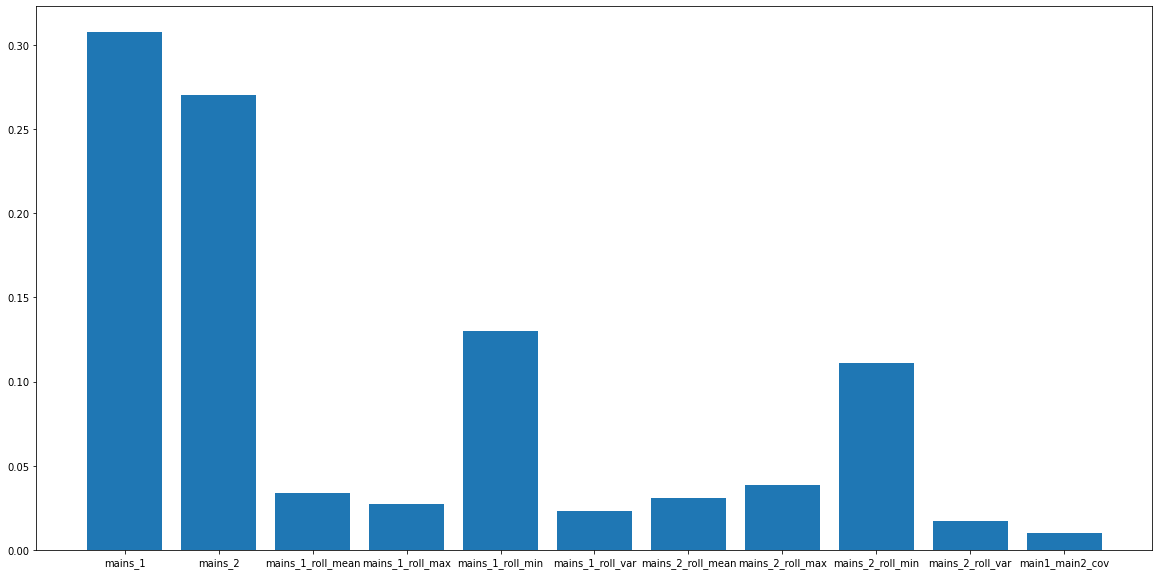

In [101]:
plt.rcParams["figure.figsize"] = (20,10)
importance = ref_model.feature_importances_
# summarize feature importance
for i,v in enumerate(list(zip(features,importance))):
    print('Feature: {}, Score: {}'.format(v[0],v[1]))
# plot feature importance
plt.bar(features, importance)
plt.show()